In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time

from collections.abc import Iterable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

In [2]:
class ColorImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2RGB, transform=transforms.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(f'{path}/{file}') for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]

        self.imgs = imgs
        self.transform = transform
        self.channels = {'r':0, 'g':1, 'b':2}

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
                return imgs
        else:
            return self.transform(self.imgs[subscript])

    def __call__(self, channel):
        try:
            imgs = []
            for img in self.imgs:
                img = img[:, :, self.channels[channel]]
                img = self.transform(img)
                imgs.append(img)

            return imgs
        except IndexError:
            raise ValueError('Only one color channel is available.', )


#### Custom transformation class to resize images with ```OpenCV``` and later this class instance use with other transformation classes with ```transforms.Compose```.

In [3]:
class OpenCVResize(object):

    def __init__(self, size):
        assert isinstance(size, int) or isinstance(size, Iterable) and len(size) == 2
        self.size = size

    def __call__(self, pic):
        return cv2.resize(pic, dsize=self.size)


In [4]:
tf = transforms.Compose({
    OpenCVResize(size=(320, 180)),
    transforms.ToTensor()
})

gray_dataset = ColorImageDataset(path='../dataset/color', transform=tf, code=cv2.COLOR_BGR2GRAY)
rgb_dataset = ColorImageDataset(path='../dataset/color', transform=tf)

In [5]:
torch.manual_seed(72)

# GRAYSCALE IMAGES USE TO TRAIN NEURAL NETWORKS.
gray_data_loader = DataLoader(dataset=gray_dataset, batch_size=12, shuffle=False)
# COLOR IMAGES JUST FOR VISUALIZATION PURPOSE.
rgb_data_loader = DataLoader(dataset=rgb_dataset, batch_size=12, shuffle=False)

#### View a single batch grayscale and colored image sample.

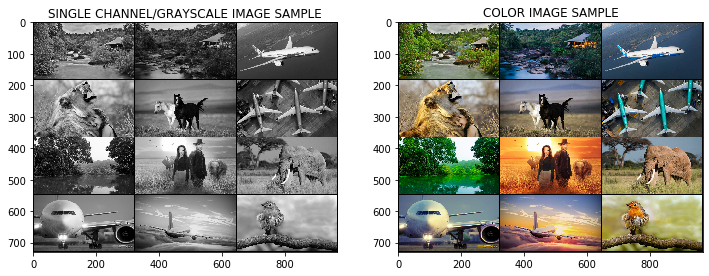

In [6]:
g_ims, rgb_ims = None, None
for g_ims in gray_data_loader:
    break

for rgb_ims in rgb_data_loader:
    break

plt.figure(figsize=(12, 10))

im = make_grid(g_ims, nrow=3, normalize=True)

plt.subplot(121)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("SINGLE CHANNEL/GRAYSCALE IMAGE SAMPLE")

im = make_grid(rgb_ims, nrow=3, normalize=True)

plt.subplot(122)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("COLOR IMAGE SAMPLE")
plt.show()

#### Derive color channels individually from colored images includes a visualization.

In [14]:
torch.manual_seed(72)

hue_loader = DataLoader(dataset=hls_dataset(channel='h'), batch_size=12, shuffle=False)
light_loader = DataLoader(dataset=hls_dataset(channel='l'), batch_size=12, shuffle=False)
saturation_loader = DataLoader(dataset=hls_dataset(channel='s'), batch_size=12, shuffle=False)

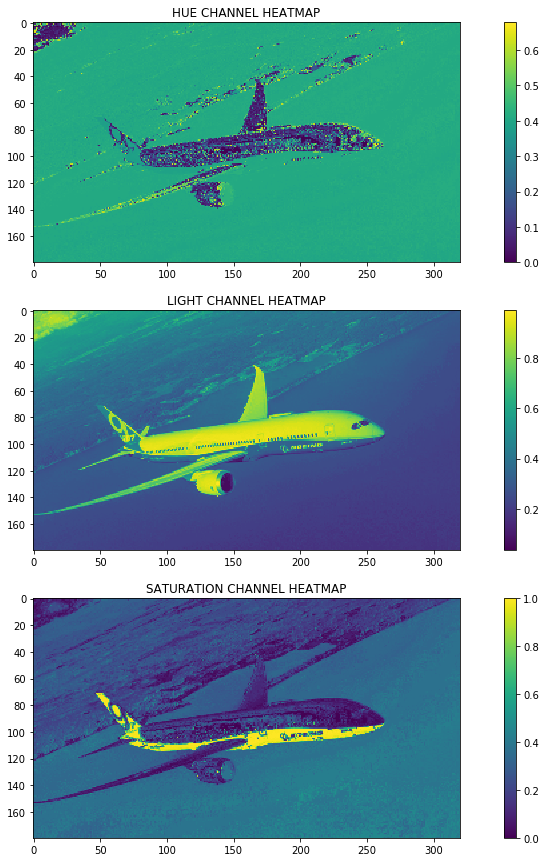

In [15]:
h_img, l_img, s_img = None, None, None
for h_img in hue_loader:
    break

for l_img in light_loader:
    break

for s_img in saturation_loader:
    break

plt.figure(figsize=(16, 15))

plt.subplot(311)
plt.imshow(h_img[2].view(180, -1))
plt.colorbar()
plt.title('HUE CHANNEL HEATMAP')

plt.subplot(312)
plt.imshow(l_img[2].view(180, -1))
plt.colorbar()
plt.title('LIGHT CHANNEL HEATMAP')

plt.subplot(313)
plt.imshow(s_img[2].view(180, -1))
plt.colorbar()
plt.title('SATURATION CHANNEL HEATMAP')
plt.show()

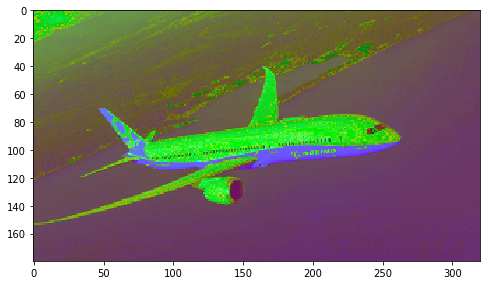

In [10]:
plt.figure(figsize=(8, 7))
plt.imshow(np.transpose(hls_ims[2], axes=(1, 2, 0)))

####  Convolutional Neural Network Model

In [52]:
class HLSNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=18, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=18, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(20)
        self.norm2 = nn.BatchNorm2d(32)
        self.norm3 = nn.BatchNorm2d(64)
        self.norm4 = nn.BatchNorm2d(18)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.norm1(X)
        X = F.relu(self.conv2(X))
        X = self.norm2(X)
        X = F.relu(self.conv3(X))
        X = self.norm3(X)
        X = F.relu((self.conv4(X)))
        X = self.norm4(X)
        return self.conv5(X)

In [54]:
hueModel = HLSNet()
lightModel = HLSNet()
saturationModel = HLSNet()

print(hueModel, lightModel, saturationModel, sep="\n")

HLSNet(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(18, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
HLSNet(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (co

#### Training Neural Network Models


In [55]:
criterion = nn.MSELoss()
hue_optimizer = torch.optim.Adam(hueModel.parameters(), lr=0.01)
light_optimizer = torch.optim.Adam(lightModel.parameters(), lr=0.01)
saturation_optimizer = torch.optim.Adam(saturationModel.parameters(), lr=0.01)

In [56]:
epoch = 3
hue_losses = []
light_losses = []
saturation_losses = []

start = time.time()

for i in range(epoch):
    i += 1

    # TRAIN RED MODEL.
    for batch, (X, y) in enumerate(zip(gray_data_loader, hue_loader)):
        batch += 1

        y_pred = hueModel(X)
        loss = criterion(y_pred, y)

        hue_losses.append(loss)

        print(f'(RED) Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        hue_optimizer.zero_grad()
        loss.backward()
        hue_optimizer.step()

    # TRAIN GREEN MODEL.
    for batch, (X, y) in enumerate(zip(gray_data_loader, light_loader)):
        batch += 1

        y_pred = lightModel(X)
        loss = criterion(y_pred, y)

        light_losses.append(loss)

        print(f'(GREEN) Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        light_optimizer.zero_grad()
        loss.backward()
        light_optimizer.step()

    # TRAIN BLUE MODEL
    for batch, (X, y) in enumerate(zip(gray_data_loader, saturation_loader)):
        batch += 1

        y_pred = saturationModel(X)
        loss = criterion(y_pred, y)

        saturation_losses.append(loss)

        print(f'(BLUE) Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        saturation_optimizer.zero_grad()
        loss.backward()
        saturation_optimizer.step()

duration = time.time() - start
print(f'Duration to total execution: {duration / 60:.2f} minutes')

(RED) Epoch: 1, Batch: 1 -> Loss: 0.2672516107559204
(RED) Epoch: 1, Batch: 2 -> Loss: 0.5417674779891968
(RED) Epoch: 1, Batch: 3 -> Loss: 0.4077768623828888
(RED) Epoch: 1, Batch: 4 -> Loss: 0.33135128021240234
(RED) Epoch: 1, Batch: 5 -> Loss: 0.2969799339771271
(GREEN) Epoch: 1, Batch: 1 -> Loss: 0.40506845712661743
(GREEN) Epoch: 1, Batch: 2 -> Loss: 1.2329633235931396
(GREEN) Epoch: 1, Batch: 3 -> Loss: 0.4974864423274994
(GREEN) Epoch: 1, Batch: 4 -> Loss: 0.26149269938468933
(GREEN) Epoch: 1, Batch: 5 -> Loss: 0.32311132550239563
(BLUE) Epoch: 1, Batch: 1 -> Loss: 0.4683581590652466
(BLUE) Epoch: 1, Batch: 2 -> Loss: 0.8275911211967468
(BLUE) Epoch: 1, Batch: 3 -> Loss: 0.37437209486961365
(BLUE) Epoch: 1, Batch: 4 -> Loss: 0.35504576563835144
(BLUE) Epoch: 1, Batch: 5 -> Loss: 0.22650617361068726
(RED) Epoch: 2, Batch: 1 -> Loss: 0.1466372311115265
(RED) Epoch: 2, Batch: 2 -> Loss: 0.15905879437923431
(RED) Epoch: 2, Batch: 3 -> Loss: 0.11192161589860916
(RED) Epoch: 2, Batch:

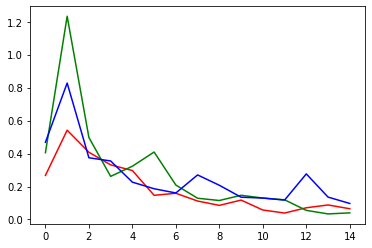

In [57]:
plt.plot(hue_losses, 'r')
plt.plot(light_losses, 'g')
plt.plot(saturation_losses, 'b')

#### Validate images with same dataset used to train.

In [71]:
@torch.no_grad()
def validate(img):

    hueModel.eval()
    lightModel.eval()
    saturationModel.eval()

    him = hueModel(img)
    lim = lightModel(img)
    sim = saturationModel(img)

    fim = torch.stack([him.view(-1, 320), lim.view(-1, 320), sim.view(-1, 320)], dim=0)

    print(fim.shape)

    img = cv2.cvtColor(np.transpose(fim.numpy(), axes=(1, 2, 0)), code=cv2.COLOR_HLS2RGB)
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 180, 320])


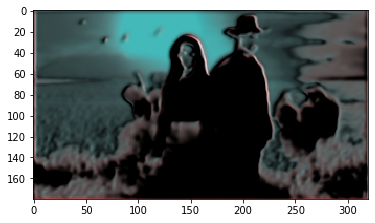

In [72]:
validate(g_ims[7].view(-1, 1, 180, 320))